In [1]:
import pandas as pd

In [2]:
LOW_CREDIBILITY_THR = 45.0

In [3]:
dtype = {'tweet_id': str,
         'user_id': str,
         'retweeted_user_id': str,
         'retweeted_status_id': str}

observation_df = pd.read_csv("data/observation_retweets.csv", parse_dates=[1], dtype=dtype)
evaluation_df = pd.read_csv("data/evaluation_retweets.csv", parse_dates=[1], dtype=dtype)

In [4]:
observation_df

,tweet_id,created_at,user_id,retweeted_user_id,retweeted_status_id,retweet_count,likes_count,retweeted_text,root_domains,newsguard_rating
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1017807360075665408,1340325850378592257,4,0,@GagliardoneS @amnesia96225614 https://t.co/L3...,affaritaliani.it,64.5
1,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,NaN,NaN,0,0,NaN,lastampa.it,95.0
2,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,NaN,NaN,0,0,NaN,nytimes.com,100.0
3,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,NaN,NaN,1,3,NaN,imolaoggi.it,5.0
4,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,NaN,NaN,0,0,NaN,repubblica.it tweetedtimes.com,95.0
...,...,...,...,...,...,...,...,...,...,...
164525,1366174375318274048,2021-02-28 23:52:08+00:00,2647427506,454423746,1366062410277208065,0,0,"Il ""percorso preferenziale"" per i giornalisti ...",gonews.it,95.0
164526,1366174768962162691,2021-02-28 23:53:41+00:00,268452474,NaN,NaN,0,0,NaN,ilmessaggero.it,95.0
164527,1366175279174086659,2021-02-28 23:55:43+00:00,1262358617803587585,NaN,NaN,0,0,NaN,informazione.it,70.0
164528,1366175279635390466,2021-02-28 23:55:43+00:00,1262358617803587585,NaN,NaN,0,0,NaN,informazione.it,70.0


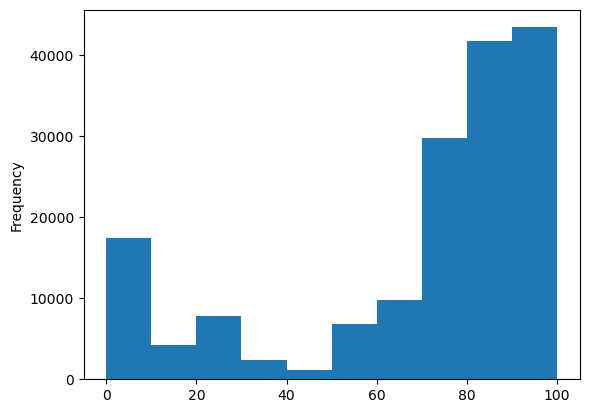

In [5]:
observation_df.newsguard_rating.plot.hist();

In [6]:
len(observation_df[observation_df.newsguard_rating <= 45.0])

32263

In [7]:
len(evaluation_df[evaluation_df.newsguard_rating <= 45.0])

212472

In [8]:
def get_retweet_network(retweets_df, low_cred_thr=None):
    
    features = ["retweeted_user_id", "user_id", "newsguard_rating"]
    edge_list_df = retweets_df[features].copy()
    
    if low_cred_thr:
        # Remove rows with no low credibility
        low_credibility_index = edge_list_df[edge_list_df.newsguard_rating > LOW_CREDIBILITY_THR].index
        edge_list_df.drop(low_credibility_index, inplace=True)
    
    edge_list_df = edge_list_df.groupby(["retweeted_user_id", "user_id"]).count()
    edge_list_df.sort_values(by="newsguard_rating", ascending=False, inplace=True)
    edge_list_df.reset_index(inplace=True)
    
    edge_list_df.rename(columns = {"retweeted_user_id": "source",
                                   "user_id": "target",
                                   "newsguard_rating": "weight"}, inplace=True)
    
    return edge_list_df

In [9]:
observation_rt_net_df = get_retweet_network(observation_df, low_cred_thr=LOW_CREDIBILITY_THR)

In [10]:
evaluation_rt_net_df = get_retweet_network(evaluation_df, low_cred_thr=LOW_CREDIBILITY_THR)

In [11]:
# Saving the retweet networks
observation_rt_net_df.to_csv("data/observation_retweet_network.csv", index=False)
evaluation_rt_net_df.to_csv("data/evaluation_retweet_network.csv", index=False)

In [12]:
# Bulding a sample retweet network
sample_rt_net = get_retweet_network(evaluation_df)

In [13]:
sample_rt_net

,source,target,weight
0,331617619,1084450777748459520,863
1,331617619,948578516982956035,378
2,331617619,1062583370,344
3,331617619,1156225273928527872,312
4,1683455144,1174780873075544069,261
...,...,...,...
182810,144210805,1040656665979305984,1
182811,144210805,10414102,1
182812,144210805,1056094116,1
182813,144210805,1067008310,1


In [14]:
import networkx as nx

In [15]:
G = nx.from_pandas_edgelist(sample_rt_net,
                            source='source',
                            target='target',
                            edge_attr='weight',
                            create_using=nx.DiGraph)

In [16]:
# Number of isolated directed subgraphs
nx.number_weakly_connected_components(G)

727

In [17]:
# Create sub-graph for each connected component
S = [G.subgraph(c).copy() for c in nx.weakly_connected_components(G)]

In [18]:
# Score each connected component and rank by the number of nodes
wcc_rank = [(s, s.number_of_nodes(), s.number_of_edges()) for s in S]
wcc_rank.sort(key=lambda x: x[1], reverse=True)

In [19]:
# Top 5
wcc_rank[:5]

[(<networkx.classes.digraph.DiGraph at 0x158d1b390>, 42186, 181480),
 (<networkx.classes.digraph.DiGraph at 0x161087110>, 106, 106),
 (<networkx.classes.digraph.DiGraph at 0x1611f48d0>, 75, 74),
 (<networkx.classes.digraph.DiGraph at 0x1610d2890>, 32, 31),
 (<networkx.classes.digraph.DiGraph at 0x1610a1010>, 25, 24)]

In [20]:
giant_component = wcc_rank[0][0]

In [21]:
degree_sequence = sorted((d for n, d in giant_component.degree()), reverse=True)
print("Maximum degree", degree_sequence[0])

Maximum degree 4577


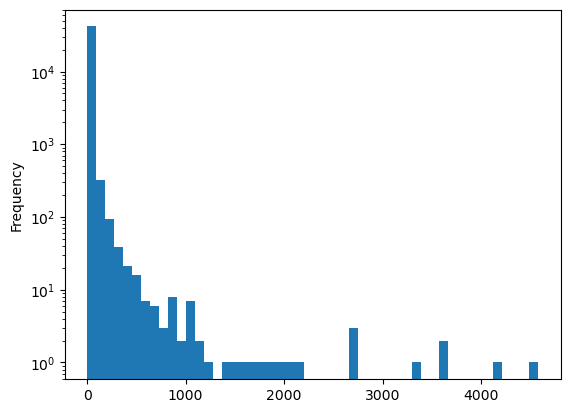

In [22]:
# Degree distribution
pd.Series(degree_sequence).plot.hist(bins=50, logy=True);

## Sample component

In [23]:
import random as rnd
rnd.seed(27) #42 # 37 #69 #27
sample_size = 5000
sampled_nodes = rnd.sample([node for node in giant_component.nodes], k=sample_size)
sampled_G = G.subgraph(sampled_nodes)
sampled_components = nx.weakly_connected_components(sampled_G)
S = [sampled_G.subgraph(c).copy() for c in sampled_components]

In [24]:
# Score each connected component and rank by the number of nodes
wcc_rank = [(s, s.number_of_nodes(), s.number_of_edges()) for s in S]
wcc_rank.sort(key=lambda x: x[1], reverse=True)
print("Top 5 weakly connected components by number of nodes\n")
[print(wcc_rank[n]) for n, _ in enumerate(wcc_rank[:5])];

Top 5 weakly connected components by number of nodes

(<networkx.classes.digraph.DiGraph object at 0x1615298d0>, 1069, 1930)
(<networkx.classes.digraph.DiGraph object at 0x1615728d0>, 14, 13)
(<networkx.classes.digraph.DiGraph object at 0x161601fd0>, 12, 11)
(<networkx.classes.digraph.DiGraph object at 0x1615c2090>, 8, 7)
(<networkx.classes.digraph.DiGraph object at 0x16148cf10>, 7, 6)


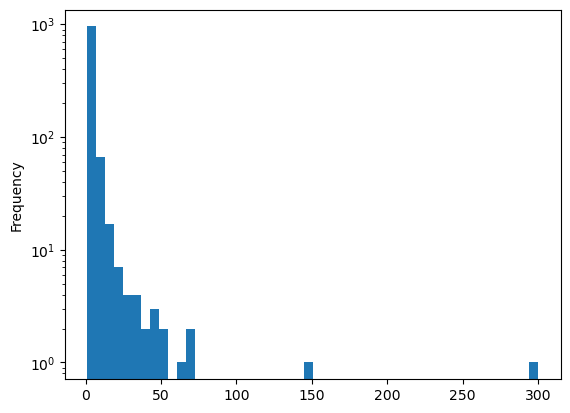

In [25]:
degree_sequence = sorted((d for n, d in wcc_rank[0][0].degree()), reverse=True)
pd.Series(degree_sequence).plot.hist(bins=50, logy=True);